In [1]:
'''
Zé Fonseca

2/02/16

Test what happens when we fit y=mx+b and de have errors in y and x
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
#from scipy.interpolate import griddata, splrep, splev, bisplrep, bisplev
#import sys
from copy import deepcopy
import emcee
%matplotlib inline
import time

In [25]:
#functions
#cosmological functions
#general functions

def func(x,m=1,b=1):
    return m*x+b

#class for fake data. Only reason to use class is because this is a copy of another iPython Notebook

class fkd:
    def __init__(self,name,N=1000,m=1,b=1,sig_y=0.01,sig_x=0.04):
        #parameters used
        self.N=N
        x=np.random.rand(N)
        x.sort()
        self.x=x
        self.y_t=m*self.x+b
        self.y=self.y_t+np.random.randn(N)*sig_y
        self.x2=x+np.random.randn(N)*sig_x
        self.sig_y=sig_y
        self.sig_x=sig_x
        self.dataset=name


In [26]:
#initiate data and simulate it
fd=fkd('test_linear')

# save data and plot it

def save_sim_data(data):
    np.savetxt('data_'+data.dataset+'_zf.txt',np.c_[data.x,data.x2,data.y],fmt='%2.3f',header="x  x2  y")

save_sim_data(fd)

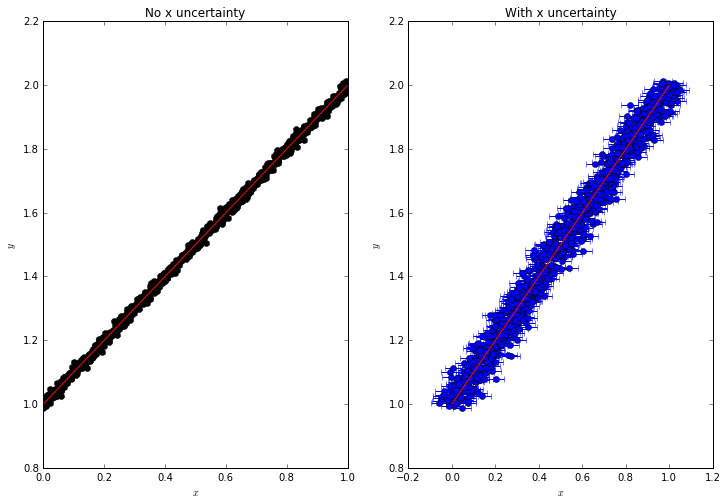

In [27]:
f, axarr = plt.subplots(1,2,figsize=(12,8))
    
axarr[0].errorbar(fd.x,fd.y,yerr=[0.005*np.ones(fd.N),0.005*np.ones(fd.N)],fmt='ko')
axarr[0].plot(fd.x,fd.y_t,'r')
axarr[0].set_xlabel(r'$x$')
axarr[0].set_ylabel(r'$y$')
axarr[0].set_title('No x uncertainty')
    
axarr[1].errorbar(fd.x2,fd.y,xerr=[0.04*np.ones(fd.N),0.04*np.ones(fd.N)],yerr=[0.005*np.ones(fd.N),0.005*np.ones(fd.N)],fmt='bo')
axarr[1].plot(fd.x,fd.y_t,'r')
axarr[1].set_xlabel(r'$x$')
axarr[1].set_ylabel(r'$y$')
axarr[1].set_title('With x uncertainty')

#plt.savefig('datasets_allcases_'+data.dataset+'_zf.pdf')
plt.show()

In [28]:
#MCMC priors

def cos_prior(p):
    """Apply a flat prior to cosmological parameters"""
    bounds = [[-2, 2], [-5, 5]]
    for i in range(len(bounds)):
        if p[i]< bounds[i][0] or p[i] > bounds[i][1]:
            return False
    return True
    
def chi2_p(o,t,sigma2):
    return (o-t)**2/sigma2


In [29]:
def log_like_fixsig(p,data):
    """
    Edited from Michelle Lochner
    ln(posterior probability) function. Combines likelihood and prior.
    Parameters
    ----------
    p : list or np.array
        Array of parameters
    data : class with the data
    Returns
    -------
    log(posterior) : float
    
    """
    if not cos_prior(p):
        return -np.inf
    
    m,b = p[:2]    
    y_t = func(data.x,m,b)
    chi2 = np.sum(chi2_p(data.y,y_t,data.sig_y**2))   
    return -0.5*chi2

def log_like_varsig(p,data):
    """
    Edited from Michelle Lochner
    Error varies at every step
    ln(posterior probability) function. Combines likelihood and prior.
    Parameters
    ----------
    p : list or np.array
        Array of parameters
    data : class with the data
    Returns
    -------
    log(posterior) : float
    
    """
    if not cos_prior(p):
        return -np.inf
    
    m,b = p[:2]    
    y_t = func(data.x,m,b)
    sigma2=data.sig_y**2+(m*data.sig_x)**2
    return -sum(chi2_p(data.y,y_t,sigma2)+np.log(sigma2))*0.5


In [30]:
def run_chain(lnprob,data,start_point=[1.1,0.9], proposal_spread=[0.05, 0.05],
             nwalkers=100, ndim=2):
    """Function to run emcee on a dataset (suppied in args)"""
    t1 = time.time()
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))*np.array(proposal_spread) + np.array(start_point)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data])
    pos, prob, state = sampler.run_mcmc(p0,50)
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos,1000)
    
    m=sampler.flatchain[:,0]
    b=sampler.flatchain[:,1]
    acceptr=sampler.acceptance_fraction.mean()
    if lnprob==log_like_varsig:
        if hasattr(data, 'xn_chain_m'):
            data.xn_chain_m=np.column_stack((data.xn_chain_m,m))
            data.xn_chain_b=np.column_stack((data.xn_chain_b,b))
            data.xn_acceptr=np.column_stack((data.xn_acceptr,acceptr))
        else:
            data.xn_chain_m=m
            data.xn_chain_b=b
            data.xn_acceptr=acceptr
    else:
        if hasattr(data, 'chain_m'):
            data.chain_m=np.column_stack((data.chain_m,m))
            data.chain_b=np.column_stack((data.chain_b,b))
            data.acceptr=np.column_stack((data.acceptr,acceptr))
        else:
            data.chain_m=m
            data.chain_b=b
            data.acceptr=acceptr
            
    print('Dataset', data.dataset)

    print('Time taken', time.time() - t1)
    print('Average acceptance ratio', sampler.acceptance_fraction.mean())


In [31]:
#run all cases 1 chains
for i in range(3):
    run_chain(log_like_fixsig,fd)
    run_chain(log_like_varsig,fd)

Dataset test_linear
Time taken 3.0554749965667725
Average acceptance ratio 0.71261
Dataset test_linear
Time taken 13.448987007141113
Average acceptance ratio 0.71373
Dataset test_linear
Time taken 2.775643825531006
Average acceptance ratio 0.70845
Dataset test_linear
Time taken 13.540580987930298
Average acceptance ratio 0.71419
Dataset test_linear
Time taken 2.7203190326690674
Average acceptance ratio 0.71235
Dataset test_linear
Time taken 13.474900007247925
Average acceptance ratio 0.71402


In [39]:
def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95

def plot_contour_hist(data,burn_tail=0,thining=1,nb=25,chain=0):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    #Neff=len(fd.chain_m[burn_tail::thining,chain])
    
    #Hist_mcmc, medges,bedges = np.histogram2d(data.chain_m[burn_tail::thining,chain],data.chain_b[burn_tail::thining,chain],bins=(nb, nb))
    #m_c=np.array([(medges[i]+medges[i+1])/2 for i in range(len(medges)-1)])
    #b_c=np.array([(bedges[i]+bedges[i+1])/2 for i in range(len(bedges)-1)])
    #Nmax,N68,N95=confidence_levels(Hist_mcmc,Neff)
    
    bins_m=[round(x*0.001+0.75,3) for x in range(0,500)]
    bins_b=[round(x*0.001+0.75,3) for x in range(0,500)]

    m2=data.xn_chain_m[burn_tail::thining,chain]
    b2=data.xn_chain_b[burn_tail::thining,chain]
        
    #Hist_mcmc2, medges2,bedges2 = np.histogram2d(m2,b2,bins=(nb, nb))
    #m_c2=np.array([(medges2[i]+medges2[i+1])/2 for i in range(len(medges2)-1)])
    #b_c2=np.array([(bedges2[i]+bedges2[i+1])/2 for i in range(len(bedges2)-1)])
    #Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff)
    
    f.text(0.5, 0.95, 'Bias: Inclusion of m in the denominator',horizontalalignment='center',verticalalignment='top')
    
    m_min=min(np.amin(data.chain_m[burn_tail::thining,chain]),np.amin(m2))
    m_max=max(np.amax(data.chain_m[burn_tail::thining,chain]),np.amax(m2))
    
    b_min=min(np.amin(data.chain_b[burn_tail::thining,chain]),np.amin(b2))
    b_max=max(np.amax(data.chain_b[burn_tail::thining,chain]),np.amax(b2))
    
    axarr[0,0].hist(data.chain_m[burn_tail::thining,chain],color='r',bins=bins_m,alpha=0.2)
    axarr[0,0].set_xlim([m_min,m_max])
    axarr[0,0].hist(m2,color='b',bins=bins_m,alpha=0.2)
    
    #import matplotlib as mpl
    #colors1 = [(1.0, 0.0, 0.0, 0.7),(1.0, 0.0, 0.0, 0.4)] 
    #cmap1 = mpl.colors.ListedColormap(colors1)
    #colors2 = [(0.0, 0.0, 1.0, 0.7),(0.0, 0.0, 1.0, 0.4)] 
    #cmap2 = mpl.colors.ListedColormap(colors2)
    
    #axarr[1,0].contourf(m_c,b_c, Hist_mcmc.T,levels=[N95,N68,Nmax], cmap=cmap1)
    #axarr[1,0].contourf(m_c2,b_c2, Hist_mcmc2.T,levels=[N952,N682,Nmax2],cmap=cmap2)
    
    axarr[1,0].scatter(data.chain_m[burn_tail::thining,chain],data.chain_b[burn_tail::thining,chain],color='r',alpha=0.05)
    axarr[1,0].scatter(data.xn_chain_m[burn_tail::thining,chain],data.xn_chain_b[burn_tail::thining,chain],color='b',alpha=0.05)
    axarr[1,0].set_xlim([m_min,m_max])
    axarr[1,0].set_ylim([b_min,b_max])
    axarr[1,0].set_ylabel(r'$b$')
    axarr[1,0].set_xlabel(r'$m$')
    
    axarr[1,1].hist(data.chain_b[burn_tail::thining,chain],bins=bins_b,color='r',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].hist(b2,bins=bins_b,color='b',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].set_ylim([b_min,b_max])
    
    plt.savefig('bias_mdenominator_zf.pdf')
    
    plt.show()


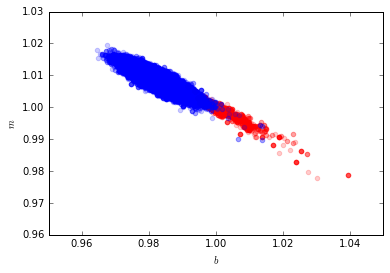

In [33]:
plt.scatter(fd.chain_m[:,0],fd.chain_b[:,0],color='r',alpha=0.2)
plt.scatter(fd.xn_chain_m[:,0],fd.xn_chain_b[:,0],color='b',alpha=0.2)
plt.ylabel(r'$m$')
plt.xlabel(r'$b$')
plt.show()

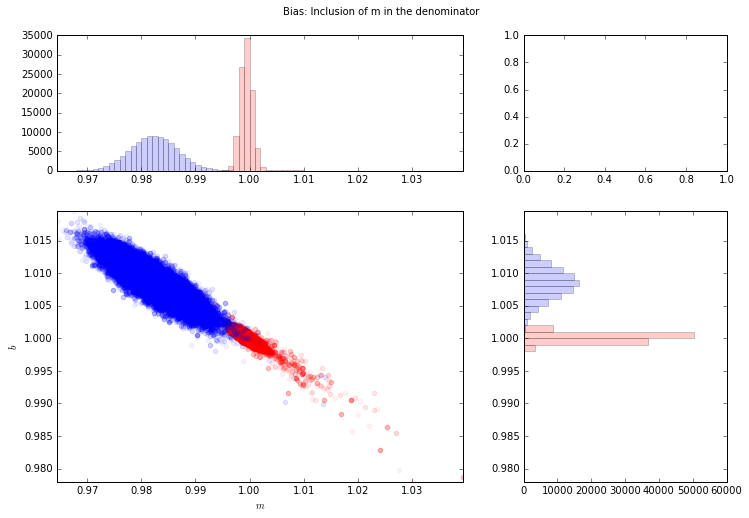

In [40]:
plot_contour_hist(fd)

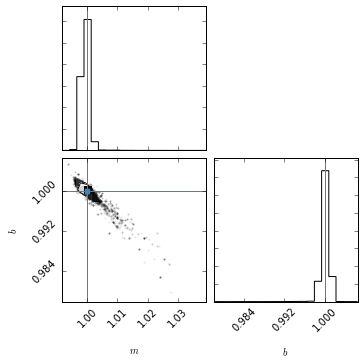

In [35]:
samples=np.c_[fd.chain_m[:,0],fd.chain_b[:,0]]
import corner
fig = corner.corner(samples, labels=["$m$", "$b$"],
                      truths=[1,1])
fig.savefig("triangle_fid.png")

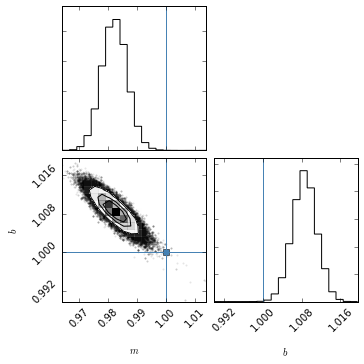

In [36]:
samples=np.c_[fd.xn_chain_m[:,0],fd.xn_chain_b[:,0]]
import corner
fig = corner.corner(samples, labels=["$m$", "$b$"],
                      truths=[1,1])
fig.savefig("triangle_quaderror.png")